In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline

# Known cities

In [4]:
daily_temperature = pd.read_csv('daily_temperature.csv', header='infer',encoding='latin1')
ciudades_temp = daily_temperature['City'].unique()

olympic_dates = pd.read_csv('olympics_dates.csv', header='infer')
olympic_dates_no_temp = olympic_dates[pd.isnull(olympic_dates['Avg temperature'])]

ciudades_no_temp = olympic_dates_no_temp['City'].unique()

ciudades_temp_available = np.intersect1d(ciudades_temp, ciudades_no_temp)

daily_temperature_filtered = daily_temperature[daily_temperature['City'].isin(ciudades_temp_available)]

daily_temperature_filtered['AvgTemperature'] = daily_temperature_filtered['AvgTemperature'].replace(-99, float('NaN'))
daily_temperature_filtered = daily_temperature_filtered.dropna(subset=['AvgTemperature'])


C:\Users\Fran\AppData\Local\Temp\ipykernel_15132\1411505432.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_temperature_filtered['AvgTemperature'] = daily_temperature_filtered['AvgTemperature'].replace(-99, float('NaN'))


In [64]:
city_models = {}
rsq_values = []

for country in ciudades_temp_available:
    data_country = daily_temperature_filtered[daily_temperature_filtered['City'] == country]
    # split the data into training and testing sets
    X = data_country[['Day', 'Month', 'Year']]
    Y = data_country['AvgTemperature']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # create a Random Forest regressor and fit the training data
    rf = RandomForestRegressor(n_estimators=112, random_state=42)
    rf.fit(X_train, y_train)

    # predict on the test data and calculate the evaluation metrics
    y_pred = rf.predict(X_test)
    rsq = rf.score(X_test, y_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    rsq_values.append(rsq)

    city_models[country] = rf

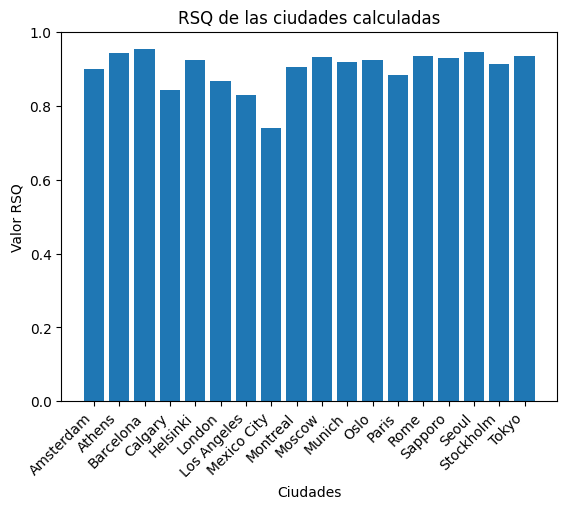

In [6]:
plt.bar(city_models.keys(), rsq_values)
plt.xlabel('Ciudades')
plt.ylabel('Valor RSQ')
plt.title('RSQ de las ciudades calculadas')

# Establecer la posición y etiquetas de las marcas del eje x
plt.xticks(rotation=45, ha='right')

plt.show()


# Unkown Cities

In [48]:
daily_temperature = pd.read_csv('daily_temperature.csv', header='infer',encoding='latin1')
ciudades_temp = daily_temperature['City'].unique()

olympic_dates = pd.read_csv('olympics_dates.csv', header='infer')
olympic_dates_no_temp = olympic_dates[pd.isnull(olympic_dates['Avg temperature'])]

ciudades_no_temp = olympic_dates_no_temp['City'].unique()

ciudades_no_temp_available = np.setdiff1d(ciudades_no_temp, ciudades_temp)

daily_temperature_filtered['AvgTemperature'] = daily_temperature_filtered['AvgTemperature'].replace(-99, float('NaN'))
daily_temperature_filtered = daily_temperature_filtered.dropna(subset=['AvgTemperature'])

In [60]:
nombres_columnas = []
localizacion_ciudades = pd.read_csv('cities15000.txt', delimiter='\t', header=None)
localizacion_ciudades = localizacion_ciudades.iloc[:, [1,2,3,4,5]]

ciudades_todas = np.concatenate((ciudades_temp, ciudades_no_temp_available))

localizacion_ciudades_filtered = localizacion_ciudades[localizacion_ciudades[2].isin(ciudades_todas)]

# Seleccionar las columnas relevantes (nombre, latitud y longitud)
localizacion_ciudades_filtered = localizacion_ciudades_filtered.iloc[:, [1, 3, 4]]

# Crear un diccionario de mapeo para los nuevos nombres de columnas
nuevos_nombres = {2: 'Ciudad', 4: 'Latitud', 5: 'Longitud'}

# Renombrar las columnas usando el método rename()
localizacion_ciudades_filtered = localizacion_ciudades_filtered.rename(columns=nuevos_nombres)

In [14]:
# Función para calcular la distancia euclidiana entre dos coordenadas geográficas
def distancia_geodesica(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en km
    R = 6371
    # Convertir las coordenadas de grados a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Calcular la distancia euclidiana entre las coordenadas
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# Función para encontrar el país más cercano a una ciudad dada
def encontrar_pais_cercano(ciudad, ciudades):
    # Buscar las coordenadas geográficas de la ciudad dada
    ci, latitud_ciudad, longitud_ciudad = localizacion_ciudades_filtered.loc[localizacion_ciudades_filtered['Ciudad'] == ciudad][0:].values[0]
    # Inicializar la distancia mínima como infinito y el país más cercano como None
    distancia_minima = np.inf
    pais_mas_cercano = None

    # Calcular la distancia entre la ciudad dada y cada uno de los países en el array
    for pais in ciudades:
        # Buscar las coordenadas geográficas del país actual
        if localizacion_ciudades_filtered['Ciudad'].isin([pais]).any():
            ci, latitud_pais, longitud_pais = localizacion_ciudades_filtered.loc[localizacion_ciudades_filtered['Ciudad'] == pais][0:].values[0]
            # Calcular la distancia geodésica entre la ciudad y el país actual
            distancia_actual = distancia_geodesica(latitud_ciudad, longitud_ciudad, latitud_pais, longitud_pais)
            # Actualizar la distancia mínima y el país más cercano si la distancia actual es menor
            if distancia_actual < distancia_minima:
                distancia_minima = distancia_actual
                pais_mas_cercano = pais

    return pais_mas_cercano

# Ejemplo de uso
ciudad = "Barcelona"
pais_cercano = encontrar_pais_cercano(ciudad, ciudades_temp)
print("El país más cercano a", ciudad, "es", pais_cercano)





El país más cercano a Barcelona es Barcelona


In [49]:
ciudades_emparejadas = {}

for city in ciudades_no_temp_available:
    ciudad = city
    if not localizacion_ciudades_filtered['Ciudad'].isin([ciudad]).any():
        pais_cercano = "No encontrado"
    else:
        pais_cercano = encontrar_pais_cercano(ciudad, ciudades_temp)
    
    ciudades_emparejadas[city] = pais_cercano

print(ciudades_emparejadas)


{'Albertville': 'Bern', 'Antwerp': 'No encontrado', 'Berlin': 'Hamburg', 'Chamonix': 'No encontrado', "Cortina d'Ampezzo": 'No encontrado', 'Garmisch-Partenkirchen': 'Munich', 'Grenoble': 'Bern', 'Innsbruck': 'Munich', 'Lake Placid': 'No encontrado', 'Lillehammer': 'Oslo', 'Sarajevo': 'Belgrade', 'Squaw Valley': 'No encontrado', 'St. Louis': 'Geneva', 'St. Moritz': 'No encontrado'}


In [57]:
city_models_2 = {}
rsq_values_2 = []

for ciudad in ciudades_no_temp_available:

    country = ciudades_emparejadas[ciudad]

    rf = None

    if country != "No encontrado":
        if country not in city_models_2.keys():
            data_country = daily_temperature[daily_temperature['City'] == country]
            # split the data into training and testing sets
            X = data_country[['Day', 'Month', 'Year']]
            Y = data_country['AvgTemperature']
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

            # create a Random Forest regressor and fit the training data
            rf = RandomForestRegressor(n_estimators=112, random_state=42)
            rf.fit(X_train, y_train)

            # predict on the test data and calculate the evaluation metrics
            y_pred = rf.predict(X_test)
            rsq = rf.score(X_test, y_test)
            rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
            rsq_values_2.append(rsq)

            city_models_2[country] = rf


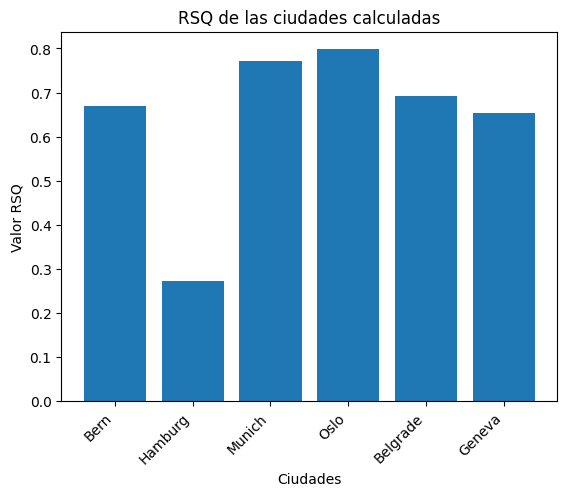

In [59]:
plt.bar(city_models_2.keys(), rsq_values_2)
plt.xlabel('Ciudades')
plt.ylabel('Valor RSQ')
plt.title('RSQ de las ciudades calculadas')

# Establecer la posición y etiquetas de las marcas del eje x
plt.xticks(rotation=45, ha='right')

plt.show()

# All cities graph

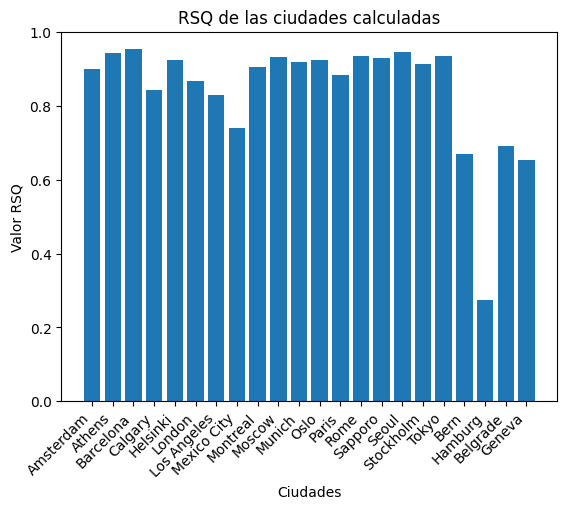

In [61]:
import matplotlib.pyplot as plt

city_models_all = list(city_models.keys()) + list(city_models_2.keys())

rsq_values_all = rsq_values + rsq_values_2

plt.bar(city_models_all, rsq_values_all)
plt.xlabel('Ciudades')
plt.ylabel('Valor RSQ')
plt.title('RSQ de las ciudades calculadas')

# Establecer la posición y etiquetas de las marcas del eje x
plt.xticks(rotation=45, ha='right')

plt.show()

# Result CSV

In [66]:
city_models.update(city_models_2)

In [70]:
def get_dates(first_date, last_date):
    day, month, year = map(int, first_date.split('/'))
    end_day, end_month, end_year = map(int, last_date.split('/'))

    dates = []
    while True:
        new_data_dict = {
            'Day': day,
            'Month': month,
            'Year': year
        }
        dates.append(pd.DataFrame([new_data_dict]))

        if day == end_day and month == end_month and year == end_year:
            break

        # Incrementar el día
        day += 1

        # Comprobar si se llegó al último día del mes
        if day > 31 or (month == 2 and day > 28) or ((month == 4 or month == 6 or month == 9 or month == 11) and day > 30):
            day = 1
            month += 1

        # Comprobar si se llegó al último mes del año
        if month > 12:
            month = 1
            year += 1

    return dates

In [77]:
olympic_dates = pd.read_csv('olympics_dates.csv', header='infer')
olympic_dates_no_temp = olympic_dates[pd.isnull(olympic_dates['Avg temperature'])]

ciudades_no_temp = olympic_dates_no_temp['City'].unique()

res = {}

for index, row in olympic_dates_no_temp.iterrows():
    ciudad = row["City"]
    dates = get_dates(row['Opening ceremony'], row['Closing ceremony'])
    if ciudad not in city_models.keys():
        ciudad = ciudades_emparejadas[ciudad]

    if ciudad != 'No encontrado':
        sum = 0
        n = 0
        for date in dates:
            sum += city_models[ciudad].predict(date)
            n += 1

    res[row["City"]] = sum/n

Paris [65.36039009]
Athens [56.24223214]
London [61.36488887]
London [71.14936975]
Helsinki [63.41623884]
Rome [69.51582341]
Bern [42.2032967]
Mexico City [61.50340402]
Munich [54.68109244]
Munich [40.82827381]
Montreal [72.55072545]
Barcelona [78.38733259]
Oslo [27.93024554]
Stockholm [64.28392857]
Amsterdam [68.38978795]
Los Angeles [67.55189732]
Hamburg [28.88470982]
Sapporo [20.72678571]
Belgrade [46.30431548]
Geneva [59.3041157]
Paris [73.26048137]
Oslo [30.21949405]
Tokyo [66.66916667]
Bern [41.58945312]
Munich [41.44326299]
Munich [39.37254464]
Moscow [63.61300223]
Los Angeles [68.34955357]
Calgary [19.15837054]
Seoul [62.93649554]
